In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime, pickle
%matplotlib inline

In [2]:
df_article = pd.read_csv('../data/nikkei_article.csv.gz')
stock_list = pd.read_csv('../data/stock_list.csv.gz')
codes = stock_list['Local Code'].astype(str)
df_price = pd.read_csv('../data/stock_price.csv.gz', index_col='EndOfDayQuote Date', parse_dates=['EndOfDayQuote Date'])
headline_features = pd.read_pickle('../data/headline_features.pkl') # 文章の特徴量を読込み
headline_features.columns = [f'feature_{i}' for i in headline_features.columns]

In [3]:
# 文章の特徴量と元データをリンクさせる
df_article.dropna(subset=['headline', 'keywords'], inplace=True)

# headlineもしくは、keywordsどちらかで人事を含むニュース記事のindexマスクを作成。
drop_mask = df_article['headline'].str.contains('人事') | df_article['keywords'].str.contains('人事')

# '人事'を含む行を除外する
df_article = df_article[~drop_mask].copy()

# 結合する
df_article = pd.concat([df_article.reset_index(drop=True), headline_features.reset_index(drop=True)], axis=1).copy()

In [4]:
# company_g.stock_codeが存在するもののみを対象とする
df_target = df_article[df_article['company_g.stock_code'].isin(codes)].copy()

In [5]:
# 日付修正処理
def convert_datetime(t):
    '''
    時刻が15時より後の場合は翌営業日の15:00に変換。それ以外は、時刻部分を15:00に変換。
    '''
    t_ret = t.replace(hour=15, minute=0, second=0)
    
    if t.time() > datetime.time(15, 0, 0):
        t_ret = t_ret + pd.offsets.BDay(1)
    
    return t_ret

df_target['publish_datetime'] = pd.to_datetime(df_target['publish_datetime'])
df_target['publish_datetime'] = df_target['publish_datetime'].apply(convert_datetime)

In [6]:
returns = {'1days':[], '5days':[], '20days':[]}
for i in df_target.index:
    # 対象銘柄の価格情報
    df_price_one_code = df_price[df_price['Local Code'] == int(df_target['company_g.stock_code'][i])]

    # ニュース公表日以降を取り出し
    mask = df_price_one_code.index >= pd.to_datetime(df_target['publish_datetime'][i].date())
    df_price_one_code = df_price_one_code[mask]

    # 各リターンを格納する
    for key, num in zip(returns.keys(), [1, 5, 20]):
        try:
            returns[key].append(df_price_one_code['EndOfDayQuote ExchangeOfficialClose'].pct_change(num).dropna()[0])
        except:
            returns[key].append(np.nan)

df_target['1days_R'] = returns['1days']
df_target['5days_R'] = returns['5days']
df_target['20days_R'] = returns['20days']

In [7]:
df_target.head(3)

,article_id,publish_datetime,media_code,media_name,men_name,page_from,picture_flag,paragraph_cnt,char_length,headline,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,1days_R,5days_R,20days_R
7,TDSKDBDGXMZO5400542031122019NN1000,2020-01-01 15:00:00+09:00,TNY,日本経済新聞電子版,NaN,NaN,有,19,1778,ゴーン元会長、周到な不意打ち出国 司法批判の声明,...,0.203411,0.453875,0.399321,0.591646,-0.245139,-0.410970,-0.369061,0.017586,-0.011990,-0.060592
16,TDSKDBDGXMZO5387164027122019L41000,2020-01-01 15:00:00+09:00,TNY,日本経済新聞電子版,NaN,NaN,有,12,1347,地銀が変わる、始まったマニュアルなき大競争,...,-0.019972,0.397417,-0.016916,-0.097602,-0.441624,-0.104872,-0.636333,0.008439,-0.046414,-0.067511
19,TDSKDBDGXKZO5400896001012020MM8000,2020-01-01 15:00:00+09:00,TNY,日本経済新聞電子版,NaN,NaN,NaN,4,569,元日付のこういうコラムは、ふつうなら来し方行く末に思いをはせ、まずは新年をことほぐものである...,...,-0.458477,0.522750,-0.488461,0.549632,-0.223382,-0.032229,-0.267484,0.017586,-0.011990,-0.060592


## Dataset・モデルを作成
一旦、ランダムフォレスト(回帰・分類)で作成してみる。  
ラベルは、リターンをそのまま利用する場合とバイナリに変換した場合を試し、  
推定値と実際のリターンの相関を見てみる。

In [8]:
df_target.isnull().sum()

article_id              0
publish_datetime        0
media_code              0
media_name              0
men_name            36810
                    ...  
feature_766             0
feature_767             0
1days_R                37
5days_R               419
20days_R             2180
Length: 784, dtype: int64

In [56]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# 必要なデータだけを抽出
X_cols = headline_features.columns.values
Y_cols = ['1days_R', '5days_R', '20days_R']
XY_cols = np.append(X_cols, Y_cols)
XY = df_target[XY_cols]
XY = XY.replace([np.inf, -np.inf], np.nan) # infを除外する(後続の欠損値処理で除外される)

label_types = ['regression', 'class']
#models = {}

for label_type in label_types:
    for label_name in Y_cols:
        # 予測対象ラベルを一つに絞り、欠損値処理
        XY_ = XY[np.append(X_cols, label_name)].copy() # X + 1label
        XY_.dropna(subset=[label_name], inplace=True)
        
        # 説明変数と目的変数に分ける
        X = XY_[X_cols]
        Y = XY_[label_name]
        
        # モデルの定義
        model_name = f'RF_{label_name}_{label_type}' 
        if label_type == 'class':
            Y = (Y > 0).astype(int) # バイナリに変換
            models[model_name] = RandomForestClassifier()
        else:
            models[model_name] = RandomForestRegressor()
        
        # モデルの学習
        models[model_name].fit(X, Y) #訓練用データで学習

RF_1days_R_class
RF_5days_R_class
RF_20days_R_class


In [9]:
import pickle

save_path = '../tmp/news_classifer_models_dict.pickle'
#with open(save_path, mode='wb') as f:
#    pickle.dump(models, f)
    
# Check
with open(save_path, mode='rb') as f:
    models = pickle.load(f)

X_cols = headline_features.columns.values
Y_cols = ['1days_R', '5days_R', '20days_R']
XY_cols = np.append(X_cols, Y_cols)
XY = df_target[XY_cols]
XY = XY.replace([np.inf, -np.inf], np.nan) # infを除外する(後続の欠損値処理で除外される)

label_types = ['regression', 'class']

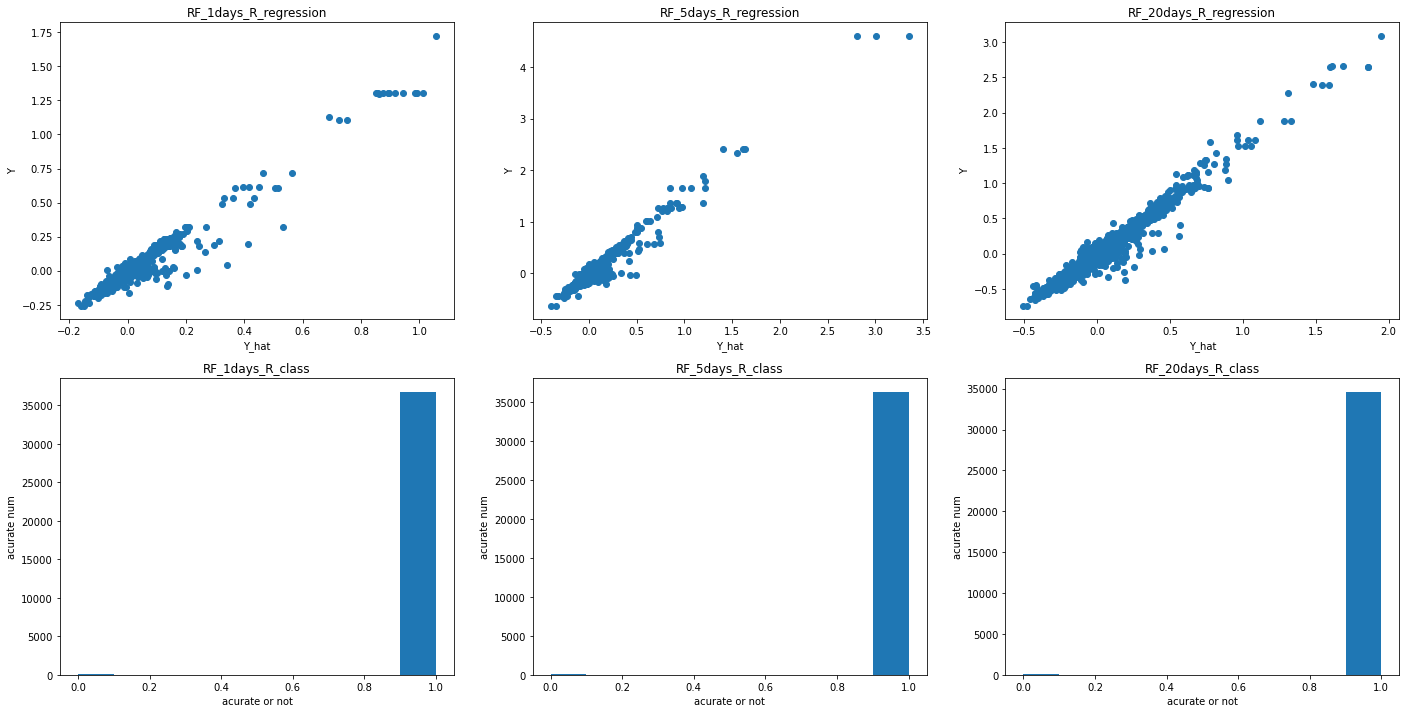

In [10]:
plt.figure(figsize=(24, 12))
i = 1

for label_type in label_types:
    for label_name in Y_cols:
        # 予測対象ラベルを一つに絞り、欠損値処理
        XY_ = XY[np.append(X_cols, label_name)].copy() # X + 1label
        XY_.dropna(subset=[label_name], inplace=True)
        
        # 説明変数と目的変数に分ける
        X = XY_[X_cols]
        Y = XY_[label_name]
        
        # モデルの読込み
        model_name = f'RF_{label_name}_{label_type}' 
        model = models[model_name]
        if label_type == 'class':
            Y = (Y > 0).astype(int) # バイナリに変換
        
        # モデルの予測
        Y_hat = model.predict(X)
        
        # 図示
        plt.subplot(2, 3, i)
        if label_type == 'class':
            plt.hist((Y_hat == Y).astype(int))
            plt.xlabel('acurate or not')
            plt.ylabel('acurate num')
        else:
            plt.scatter(Y_hat, Y)
            plt.xlabel('Y_hat')
            plt.ylabel('Y')
        
        plt.title(model_name)
        i += 1

<回帰モデル>  
推定値と真の値における散布図をプロットしてみたが、正しくスコアリングできているようすが見られる。  

<分類モデル>  
誤りは限りなく少なく、正しく分類できているように思われる。

どちらも過学習の可能性は残されているが、学習データに関しては適度に学習できているように見える。  
次は検証データ(APIから取得)を利用してモデルのスコアリング・分類精度について詳しく見ていく。

## モデルによる予測(検証)
2021年1月1日～4月1日までのニュースに対して検証。  

In [11]:
new_headline_features = pd.read_pickle('../data/new_headline_features.pkl') # 文章の特徴量を読込み
new_headline_features.columns = [f'feature_{i}' for i in new_headline_features.columns]
new_headline_features.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
publish_datetime,,,,,,,,,,,,,,,,,,,,,
2021-02-01 03:00:00+00:00,-0.221813,-0.117189,-0.027059,-0.429372,-0.465968,-0.398349,-0.426273,-0.945332,-0.677035,0.307566,...,-0.013424,0.394708,0.330190,-0.186044,0.294648,0.010738,0.504313,0.014225,0.195278,-0.205880
2021-02-01 03:00:00+00:00,0.293180,0.544346,-0.150652,-0.368188,-0.096867,0.054365,-0.221904,-0.302359,-0.041333,0.084514,...,-0.343890,0.394521,0.179113,-0.248342,0.539842,0.051515,0.489558,-0.377376,-0.262675,-0.299801
2021-01-02 20:26:10+00:00,-0.768525,-0.061710,-0.384925,-0.808628,-0.509122,-0.438665,-0.166502,-0.611114,-0.280768,-0.046412,...,0.147618,0.097615,0.283234,-0.426562,0.096131,-0.406504,0.145829,0.028686,0.174030,0.203488
2021-01-02 21:04:53+00:00,-0.091331,0.046729,0.091170,-0.261556,-0.269357,-0.138951,-0.515171,-0.305389,0.178939,0.475976,...,0.004573,-0.043914,0.341627,-0.234090,0.514499,0.338504,0.519602,-0.495312,-0.405991,0.195558
2021-02-01 05:00:00+00:00,-0.525145,-0.066837,0.435244,-0.111417,-0.052839,0.429219,0.096004,0.314612,-0.246380,0.834710,...,-0.297548,0.287070,0.530065,-0.153942,0.457494,-0.193223,0.445552,-0.652045,-0.612070,-0.203061


In [12]:
# 検証用の記事一覧を読み込む
df_new_article = pd.read_csv('../data/new_article.csv', index_col=[0])

# 文章の特徴量と元データをリンクさせる
df_new_article.dropna(subset=['headline', 'keywords'], inplace=True)

# headlineもしくは、keywordsどちらかで人事を含むニュース記事のindexマスクを作成。
drop_mask = df_new_article['headline'].str.contains('人事') | df_new_article['keywords'].str.contains('人事')

# '人事'を含む行を除外する
df_new_article = df_new_article[~drop_mask].copy()

# 結合する
df_new_article = pd.concat([df_new_article.reset_index(drop=True), new_headline_features.reset_index(drop=True)], axis=1).copy()

print(df_new_article.shape)
df_new_article.head()

(32420, 777)


,article_id,publish_datetime,media_code,media_name,men_name,headline,keywords,classifications,stock_code,feature_0,...,feature_758,feature_759,feature_760,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767
0,TDSKDBDGXMZO6837140021012021000000,2021-02-01T03:00:00Z,TNY,日本経済新聞電子版,NaN,春は色スーツに挑戦 鴨志田康人さん流コーデを映像で,鴨志田康人\nポール・スチュアート\nグレー\n装い\n色スーツ\nスーツ\n春\nコーデ\...,＄絵写表記事,NaN,-0.221813,...,-0.013424,0.394708,0.330190,-0.186044,0.294648,0.010738,0.504313,0.014225,0.195278,-0.205880
1,TDSKDBDGXZZO6852194026012021000000,2021-02-01T03:00:00Z,TNY,日本経済新聞電子版,NaN,はやぶさ２帰還 採取試料で太陽系や生命の起源解明へ,大友由美\n小玉祥司\n奥村彩香\n太陽系\nはやぶさ２\n採取試料\n小惑星探査機\n地球...,＄絵写表記事\n＃Ｗ４０１０８,NaN,0.293180,...,-0.343890,0.394521,0.179113,-0.248342,0.539842,0.051515,0.489558,-0.377376,-0.262675,-0.299801
2,TDSKDBDGXZQODG020SF002012021000000,2021-01-02T20:26:10Z,TNY,日本経済新聞電子版,NaN,会いたいけれど…我慢の正月 オンライン帰省や分散初詣,オンライン\nオンライン帰省\n分散初詣\n帰省\n我慢\n正月,＄絵写表記事\n＄社会・くらし\n＄新型コロナウイルス,NaN,-0.768525,...,0.147618,0.097615,0.283234,-0.426562,0.096131,-0.406504,0.145829,0.028686,0.174030,0.203488
3,TDSKDBDGXZQODE23AB3023122020000000,2021-01-02T21:04:53Z,TNY,日本経済新聞電子版,NaN,日本からの入国規制、26カ国・地域で強化 感染再拡大で,入国規制\n再拡大\n地域\n安倍晋三\n感染\n浜田篤郎\n菅義偉\n規制,＄絵写表記事\n＄政治\n＄新型コロナウイルス\n＃Ｗ２０４０１\n＃Ｗ２０４０４,NaN,-0.091331,...,0.004573,-0.043914,0.341627,-0.234090,0.514499,0.338504,0.519602,-0.495312,-0.405991,0.195558
4,TDSKDBDGXZQODF2850T028012021000000,2021-02-01T05:00:00Z,TNY,日本経済新聞電子版,NaN,巨大IT取引透明化法が施行、デジタル市場を適正化,デジタル市場\n取引透明化\n増島雅和\n巨大ＩＴ\n施行\n梶山弘志\n適正化,＃Ｗ２０２０１\n＃Ｗ２０２０２\n＃Ｗ５０３０１\n＃Ｗ５０３０５\n＃Ｂ０５２０,NaN,-0.525145,...,-0.297548,0.287070,0.530065,-0.153942,0.457494,-0.193223,0.445552,-0.652045,-0.612070,-0.203061


In [13]:
# company_g.stock_codeが存在するもののみを対象とする
df_new_target = df_new_article[df_new_article['stock_code'].isin(codes)].copy()
print(df_new_target.shape)

(6951, 777)


In [17]:
# 対象の株価データをJ-Quants APIから取得する
import sys
sys.path.append('../src/')
sys.path.append('../private/')

from credentials import *
from api import call_refresh_api, call_jquants_api

refreshtoken = REFRESH_TOKEN
id_token = call_refresh_api(refreshtoken)
idtk = id_token['idToken']

In [18]:
def get_stock_price(idtk:str, code:str, start:str, end:str) -> pd.DataFrame:
    paramdict = {}
    paramdict["datefrom"] = start
    paramdict["dateto"] = end
    paramdict["includedetails"] = "True"
    res = call_jquants_api(paramdict, idtk, "prices", code)
    return pd.DataFrame(res['prices'])

In [19]:
get_stock_price(idtk, '5802', '2021-01-01', '2021-04-27')

,EndOfDayQuote Open,EndOfDayQuote PreviousClose,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote VWAP,EndOfDayQuote Low,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote High,EndOfDayQuote Date,EndOfDayQuote Close,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote PreviousCloseDate,Local Code,EndOfDayQuote Volume
0,1366.0,1366.5,1.0,1346.695,1336.0,1366.5,1371.5,2021/01/04,1343.0,2020/12/30,1343.0,-23.5,-1.720,2020/12/30,5802,1748500.0
1,1330.0,1343.0,1.0,1337.835,1329.0,1343.0,1346.0,2021/01/05,1341.0,2021/01/04,1341.0,-2.0,-0.149,2021/01/04,5802,1933400.0
2,1335.0,1341.0,1.0,1340.862,1326.0,1341.0,1349.5,2021/01/06,1348.0,2021/01/05,1348.0,7.0,0.522,2021/01/05,5802,1925900.0
3,1387.0,1348.0,1.0,1402.352,1374.0,1348.0,1416.0,2021/01/07,1407.5,2021/01/06,1407.5,59.5,4.414,2021/01/06,5802,3974600.0
4,1437.5,1407.5,1.0,1465.873,1428.0,1407.5,1488.5,2021/01/08,1488.5,2021/01/07,1488.5,81.0,5.755,2021/01/07,5802,5921200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,1700.0,1691.0,1.0,1711.968,1696.5,1691.0,1721.0,2021/04/19,1713.0,2021/04/16,1713.0,22.0,1.301,2021/04/16,5802,1823600.0
73,1692.5,1713.0,1.0,1671.670,1658.5,1713.0,1695.0,2021/04/20,1672.5,2021/04/19,1672.5,-40.5,-2.364,2021/04/19,5802,2382000.0
74,1632.5,1672.5,1.0,1620.060,1610.5,1672.5,1643.5,2021/04/21,1615.5,2021/04/20,1615.5,-57.0,-3.408,2021/04/20,5802,2230100.0
75,1635.0,1615.5,1.0,1631.616,1620.5,1615.5,1643.0,2021/04/22,1636.0,2021/04/21,1636.0,20.5,1.269,2021/04/21,5802,1822200.0


In [79]:
# 2021年1月1日～4月1日までにニュースが存在する銘柄の株価を取得し、結合する
for i, code in enumerate(set(df_new_target['stock_code'])):
    df_price_one_code = get_stock_price(idtk, code, '2021-01-01', '2021-04-27')
    if i == 0:
        df_new_price = df_price_one_code.copy()
    else:
        df_new_price = pd.concat([df_new_price, df_price_one_code], axis=0).copy()

In [14]:
#df_new_price.to_csv('../data/new_stock_price.csv')
df_new_price = pd.read_csv('../data/new_stock_price.csv', index_col=[0])
print(df_new_price.shape)

(98190, 16)


In [15]:
df_new_target['publish_datetime'] = pd.to_datetime(df_new_target['publish_datetime'])
df_new_target['publish_datetime'] = df_new_target['publish_datetime'].apply(convert_datetime)

In [16]:
df_new_price.set_index('EndOfDayQuote Date', inplace=True)
df_new_price.index = pd.to_datetime(df_new_price.index)

In [17]:
returns = {'1days':[], '5days':[], '20days':[]}

for i in df_new_target.index:
    # 対象銘柄の価格情報
    df_price_one_code = df_new_price[df_new_price['Local Code'] == int(df_new_target['stock_code'][i])]

    # ニュース公表日以降を取り出し
    mask = df_price_one_code.index >= pd.to_datetime(df_new_target['publish_datetime'][i].date())
    df_price_one_code = df_price_one_code[mask]

    # 各リターンを格納する
    for key, num in zip(returns.keys(), [1, 5, 20]):
        try:
            returns[key].append(df_price_one_code['EndOfDayQuote ExchangeOfficialClose'].pct_change(num).dropna()[0])
        except:
            returns[key].append(np.nan)

df_new_target['1days_R'] = returns['1days']
df_new_target['5days_R'] = returns['5days']
df_new_target['20days_R'] = returns['20days']

In [18]:
df_new_target.head(3)

,article_id,publish_datetime,media_code,media_name,men_name,headline,keywords,classifications,stock_code,feature_0,...,feature_761,feature_762,feature_763,feature_764,feature_765,feature_766,feature_767,1days_R,5days_R,20days_R
7,TDSKDBDGXZQOFB285XI028012021000000,2021-02-01 15:00:00+00:00,TNY,日本経済新聞電子版,NaN,首都圏の地銀・信金、夜間金庫のサービス終了広がる,サービス終了\n信用金庫\n地方銀行\n城南信用金庫\n金庫\n首都圏,＄絵写表記事\nＴ８３３７\nＰＤ４７３\nＮ００７００３４\n＄地域\n＄東京\n＄関東\...,8337,0.167979,...,0.071291,0.174647,0.185721,0.200714,-0.146291,-0.496031,0.252382,0.008439,0.088608,0.084388
11,TDSKDBDGXLRSP604201_01022021000000,2021-02-01 15:00:00+00:00,TNY,日本経済新聞電子版,NaN,エーザイ、パーキンソン病治療剤「エクフィナ」を韓国で発売,新製品\nエクフィナ\n内藤晴夫\n韓国\nエーザイ\nパーキンソン病治療剤\nエーザイ・コ...,Ｔ４５２３\nＰＤ０９２\nＮ００００６１１\n＃Ｗ１０２０９\n＃Ｗ１０２０１\n＃Ａ４１...,4523,0.287937,...,-0.058853,0.459766,-0.198747,0.447848,-0.290881,-0.233987,-0.118387,-0.011421,0.002566,-0.050430
16,TDSKDBDGXZQODZ16B23016122020000000,2021-01-03 15:00:00+00:00,TNY,日本経済新聞電子版,NaN,通販を「Amazonスルー」に 消費者と小売り直結\nポストGAFAの胎動（2）,アマゾンジャパン\nアマゾン・ドット・コム\nショッピファイ\nジャック・ドーシー\nスクエ...,＄絵写表記事\nＴ９９８３\nＰＤ４５４\nＮ００１６１６６\n＄地域\n＄中国\n＄ビジネ...,9983,-0.165007,...,-0.080301,0.500809,0.078737,0.134524,0.052887,-0.094063,0.272777,-0.020648,0.000659,0.005052


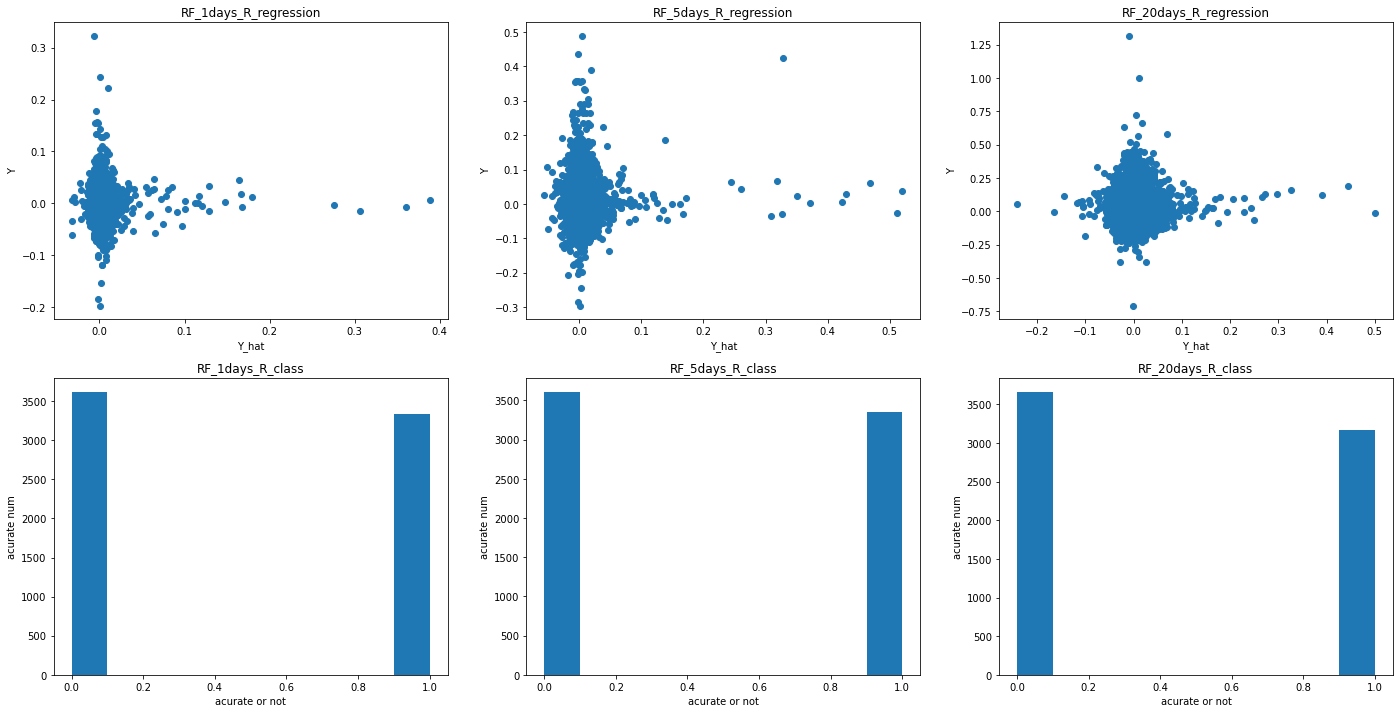

In [19]:
new_XY = df_new_target[XY_cols]
new_XY = new_XY.replace([np.inf, -np.inf], np.nan) # infを除外する(後続の欠損値処理で除外される)

plt.figure(figsize=(24, 12))
i = 1

for label_type in label_types:
    for label_name in Y_cols:
        # 予測対象ラベルを一つに絞り、欠損値処理
        XY_ = new_XY[np.append(X_cols, label_name)].copy() # X + 1label
        XY_.dropna(subset=[label_name], inplace=True)
        
        # 説明変数と目的変数に分ける
        X = XY_[X_cols]
        Y = XY_[label_name]
        
        # モデルの読込み
        model_name = f'RF_{label_name}_{label_type}' 
        model = models[model_name]
        if label_type == 'class':
            Y = (Y > 0).astype(int) # バイナリに変換
        
        # モデルの予測
        Y_hat = model.predict(X)
        
        # 図示
        plt.subplot(2, 3, i)
        if label_type == 'class':
            plt.hist((Y_hat == Y).astype(int))
            plt.xlabel('acurate or not')
            plt.ylabel('acurate num')
        else:
            plt.scatter(Y_hat, Y)
            plt.xlabel('Y_hat')
            plt.ylabel('Y')
        
        plt.title(model_name)
        i += 1

回帰モデルの予測が高い数値を算出した場合は、実際の市場リターンは0近辺に密集している様子が伺える。  
⇒インパクトの大きいニュースは市場に既に織り込まれているため、リターンにつながっていないのかもしれない。  
分類モデルにおける的中率は50％を下回っている。  
⇒分類モデルにおいて{1}と{0}のリターンの平均についてどうなっているかは要確認。

In [21]:
df_results = {}
for label_name in Y_cols:
    # 予測対象ラベルを一つに絞り、欠損値処理
    XY_ = new_XY[np.append(X_cols, label_name)].copy() # X + 1label
    XY_.dropna(subset=[label_name], inplace=True)

    # 説明変数と目的変数に分ける
    X = XY_[X_cols]
    Y = XY_[label_name]

    # モデルの読込み
    model_name = f'RF_{label_name}_class' 
    model = models[model_name]
    
    # バイナリに変換
    Y_bin = (Y > 0).astype(int) 

    # モデルの予測
    Y_hat = model.predict(X)
    
    # dfにまとめて集計
    df_results[f'{label_name}'] = pd.DataFrame({'Y':Y.values,
                                                'Y_hat':Y_hat,
                                               }).groupby(by='Y_hat').mean()

In [22]:
df_result = pd.concat([df_results['1days_R'], df_results['5days_R'], df_results['20days_R']], axis=1)
df_result.columns = Y_cols
df_result

,1days_R,5days_R,20days_R
Y_hat,,,
0,0.002781,0.010319,0.034264
1,0.002692,0.011544,0.033669


5日後リターンはラベル「1」のリターンが高くなったが、他の期間については反対の結果となっており、  
リターンの差もあまりないことから個別銘柄のクラス分類モデルは使えそうにない。  